# Detect multiple harmonics.

Work in progress...

In [1]:
# For inline plotting.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 4)

In [2]:
# Math and sound processing.
import numpy as np
import scipy.signal
import librosa
import librosa.display

In [3]:
# Settings.
sound_file = '../data_in/Mdau_TE384.wav'
#sound_file = '../data_in/Ppip_TE384.wav'
#sound_file = '../data_in/Myotis-Plecotus-Eptesicus_TE384.wav'

cutoff_freq_hz = 15000

In [4]:
# Load sound file.
signal, sr = librosa.load(sound_file, sr=None)

In [5]:
# Check if TE, Time Expansion.
sampling_freq = sr
if '_TE' in sound_file:
    sampling_freq *= 10
# Sound file info.
print('Sampling freq in file (after TE): ' + str(sr) + ' Hz.')
print('Original sampling freq: ' + str(sampling_freq) + ' Hz.')
print(str(len(signal)) + ' samples.')
print('Original rec. length: ' + str(len(signal) / sr / 10) + ' sec.')

Sampling freq in file (after TE): 38400 Hz.
Original sampling freq: 384000 Hz.
398012 samples.
Original rec. length: 1.0364895833333334 sec.


In [6]:
# Noise level. RMS, root-mean-square. Calculated for the whole file.
# (May be calculated over buffers later since weather etc. changes over time.)
noise_level = np.sqrt(np.mean(np.square(signal)))

noise_level_dbfs = 20 * np.log10(np.abs(noise_level) / 1.0)

print('Noise: ' + str(noise_level) + ' noise-dbfs: ' + str(noise_level_dbfs))

Noise: 0.0303963 noise-dbfs: -30.3435745399


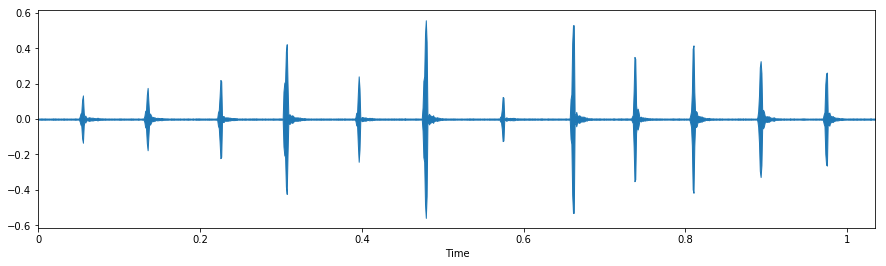

In [7]:
# Plot. Time is real time.
librosa.display.waveplot(signal, sr=sampling_freq)
plt.show()

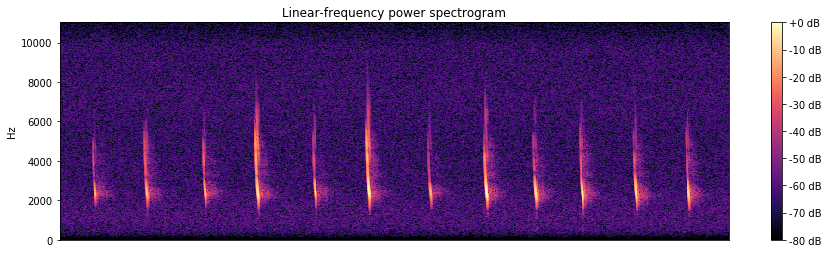

In [8]:
# Plot spectrogram. Note: Wrong Hz due to librosas default sr at 22050.
D = librosa.amplitude_to_db(librosa.stft(signal), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.show()

In [9]:
# Find peaks in time domain (rmse and localmax).
def find_peaks(y, hop_length):
    # Set all to zero in the noisy part.
    y2 = y.copy()
    rms_tot = np.sqrt(np.mean(np.square(y)))
    y2[(np.abs(y2) < (rms_tot * 1.5))] = 0.0
    # Calculate rmse over 1024 samples and move 1 ms forvard each time.
    rmse = librosa.feature.rmse(y=y2, hop_length=384, frame_length=1024, center=True)
    # Find local max in the rmse array.
    locmax = librosa.util.localmax(rmse.T)
    # From true/false array to index list.
    maxindexlist = []
    for index, a in enumerate(locmax):
        if a: maxindexlist.append(index)
    # Convert indexlist to match original signal.
    index_list = librosa.frames_to_samples(maxindexlist, hop_length=hop_length)
    return index_list

In [10]:
%%timeit
peaks = find_peaks(signal, hop_length=384)

The slowest run took 5.00 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 5.36 ms per loop


In [11]:
peaks = find_peaks(signal, hop_length=384)

In [12]:
print(len(peaks))
peaks

13


array([ 21120,  51840,  85248,  86784, 117888, 152064, 183936, 220800,
       253824, 283392, 311040, 342912, 374400])

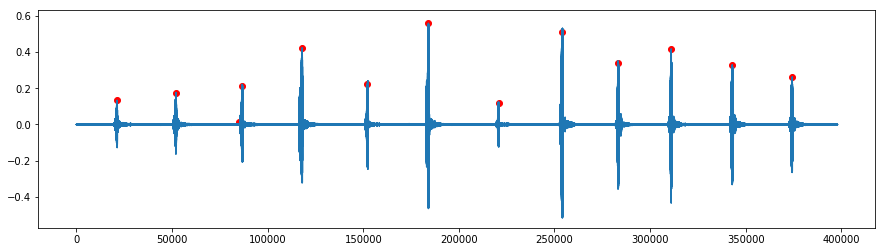

In [13]:
plt.plot(signal)
plt.scatter(peaks, [signal[x:x+200].max() for x in peaks], color='r')
plt.show()

In [14]:
# Convert frame to dBFS spectrum.
def calc_dbfs_spectrum(frame, window_function, dbfs_max):
    #print(len(signal))
    frame = frame * window_function
    spectrum = np.fft.rfft(frame)
    dbfs_spectrum = 20 * np.log10(np.abs(spectrum) / dbfs_max)
    return dbfs_spectrum

In [15]:
# Static values calculated for a specific window size.
window_size = 256
half_window = int(window_size / 2)


#hamming_window = np.hamming(window_size)
hamming_window = scipy.signal.blackmanharris(window_size)


hamming_dbfs_max = np.sum(hamming_window) / 2 # Max db value in window. DBFS = db full scale. Half spectrum used.
# Used as y array in kHz
self_freq_bins_hz = np.arange((window_size / 2) + 1) / (window_size / sampling_freq)

In [16]:
# Test
index = peaks[8]
dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                   hamming_window, hamming_dbfs_max)
dbmax=np.max(dbfs_spectrum)
dbmax

-7.6008045997752669

In [17]:
%%timeit
for index in peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)

The slowest run took 4.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 604 µs per loop


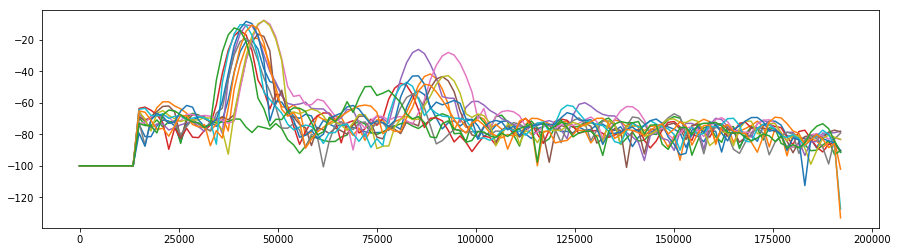

In [18]:
# Plot dBFS over frequency (Hz).
for index in peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)
    # Cut off low frequencies.
    dbfs_spectrum[(self_freq_bins_hz < cutoff_freq_hz)] = -100.0
    plt.plot(self_freq_bins_hz, dbfs_spectrum)
plt.show()

In [19]:
# List peak and dBFS.
for index in peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)
    # Cut off low frequencies.
    dbfs_spectrum[(self_freq_bins_hz < cutoff_freq_hz)] = -100.0
    # Find max.
    bin_peak_index = dbfs_spectrum.argmax()
    peak_frequency_hz = bin_peak_index * sampling_freq / window_size
    time = index / sampling_freq
    db_peak = np.max(dbfs_spectrum)
    print('Time: ' + str(time) + '  Freq.: ' + str(peak_frequency_hz) + '  dBFS peak: ' + str(db_peak))

Time: 0.055  Freq.: 43500.0  dBFS peak: -20.1500107358
Time: 0.135  Freq.: 43500.0  dBFS peak: -18.7475202166
Time: 0.222  Freq.: 28500.0  dBFS peak: -66.6647603191
Time: 0.226  Freq.: 40500.0  dBFS peak: -13.9566212674
Time: 0.307  Freq.: 42000.0  dBFS peak: -10.457108141
Time: 0.396  Freq.: 45000.0  dBFS peak: -16.2296308825
Time: 0.479  Freq.: 46500.0  dBFS peak: -7.4391742318
Time: 0.575  Freq.: 42000.0  dBFS peak: -18.9300730599
Time: 0.661  Freq.: 46500.0  dBFS peak: -7.60080459978
Time: 0.738  Freq.: 40500.0  dBFS peak: -10.2361118568
Time: 0.81  Freq.: 42000.0  dBFS peak: -8.18053394258
Time: 0.893  Freq.: 43500.0  dBFS peak: -10.5069138474
Time: 0.975  Freq.: 39000.0  dBFS peak: -12.3236710058


In [20]:
# Test.
(noise_level_dbfs / 1.5)

-20.22904969325505

Number of peaks: 1
Number of peaks: 2
Skipped. Peak level too low.
Number of peaks: 3
Number of peaks: 2
Number of peaks: 2
Number of peaks: 2
Number of peaks: 1
Number of peaks: 2
Number of peaks: 2
Number of peaks: 2
Number of peaks: 2
Number of peaks: 2


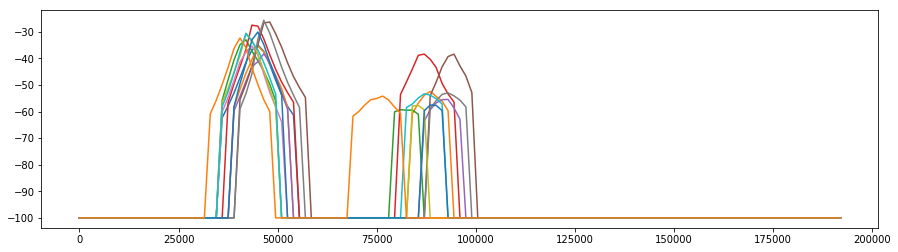

In [21]:
for index in peaks: # [peaks[5]]: # peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)
    # Cut off low frequencies.    
    dbfs_spectrum[(self_freq_bins_hz < cutoff_freq_hz)] = -100.0
    # Smoothing. Mean over frame_length.
    rmse = librosa.feature.rmse(y=dbfs_spectrum, hop_length=1, frame_length=8, center=True)
    dbfs_spectrum = - rmse[0]
    #print(dbfs_spectrum)
    
    db_peak = np.max(dbfs_spectrum)
    db_mean = np.mean(dbfs_spectrum)
    threshold_db = db_mean - (db_mean - db_peak) * 0.3
    #print('db_peak: ' + str(db_peak) + '   db_mean: ' + str(db_mean) + '   threshold_db: ' + str(threshold_db))
    if db_peak > (db_mean / 1.2):
#    if db_peak > (noise_level_dbfs / 1.2):
        dbfs_spectrum[(dbfs_spectrum < threshold_db)] = -100.0
        plt.plot(self_freq_bins_hz, dbfs_spectrum[:-1])
        locmax = librosa.util.localmax(dbfs_spectrum)
        max_index_list = []
        for index, a in enumerate(locmax):
            if a: max_index_list.append(index)
        print('Number of peaks: ' + str(len(max_index_list)))
    else:
        print('Skipped. Peak level too low.')
        
plt.show()    

# To be continued...

In [22]:
#from scipy.signal import argrelextrema
import scipy.signal

In [23]:
scipy.signal.argrelextrema(dbfs_spectrum, np.greater)[0]

array([27, 51])

[30, 62]
[30, 61]
[60, 88]
[29, 56, 84]
[30, 60]
[30, 62, 97]
[32, 64]
[29, 58, 94]
[32, 63, 97]
[28, 59, 85]
[28, 59]
[30, 60, 94]
[27, 53, 95]


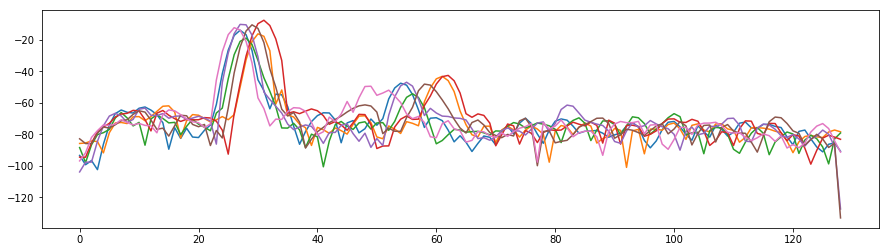

In [24]:
for index in peaks: # [peaks[5]]: # peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)
    #peakbins = scipy.signal.argrelextrema(dbfs_spectrum, np.greater)[0]
    #print(peakbins[0])
    
    # peakidx = scipy.signal.find_peaks_cwt(dbfs_spectrum, np.arange(10,15), noise_perc=0.1)
    peakidx = scipy.signal.find_peaks_cwt(dbfs_spectrum, np.arange(10,15), noise_perc=0.1)
    print(peakidx)

    if len(peakidx) == 3:
        #plt.plot(self_freq_bins_hz, dbfs_spectrum)
        plt.plot(dbfs_spectrum)


plt.show()

In [25]:
np.arange(10,15)

array([10, 11, 12, 13, 14])

29 => -20.1500107358/43500.0   [29, 57] ==> [-20.15001074 -52.22948864]


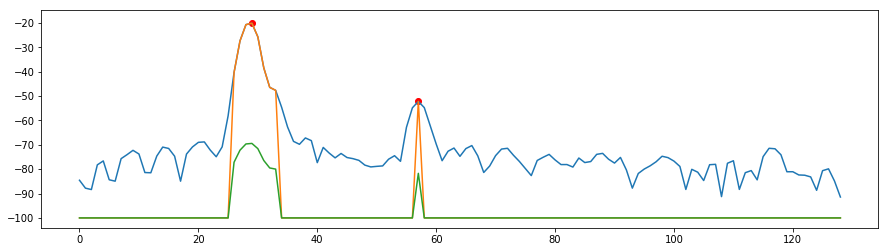

29 => -18.7475202166/43500.0   [29, 59] ==> [-18.74752022 -41.62998759]


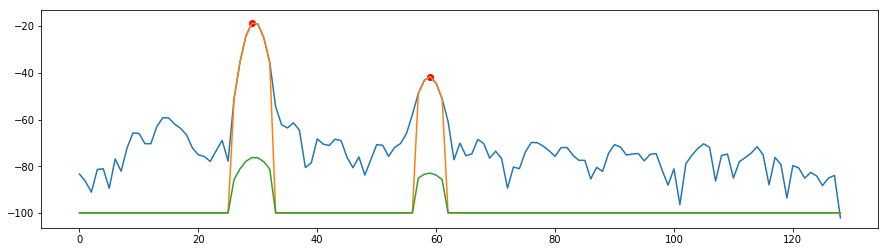

19 => -66.6647603191/28500.0   [] ==> []


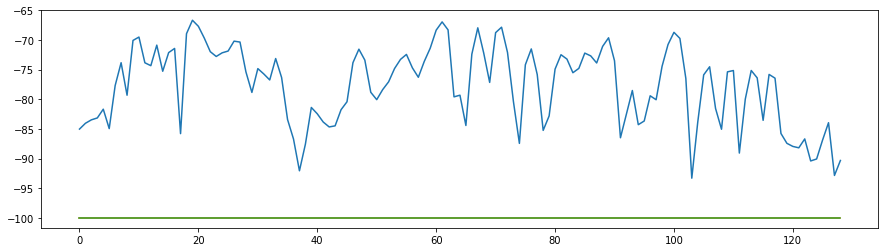

27 => -13.9566212674/40500.0   [27, 54] ==> [-13.95662127 -47.57731466]


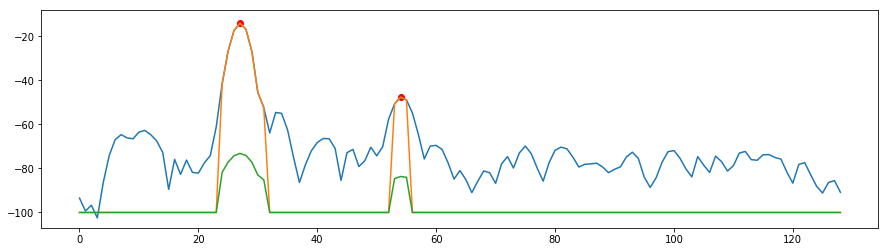

28 => -10.457108141/42000.0   [28, 57] ==> [-10.45710814 -25.97976353]


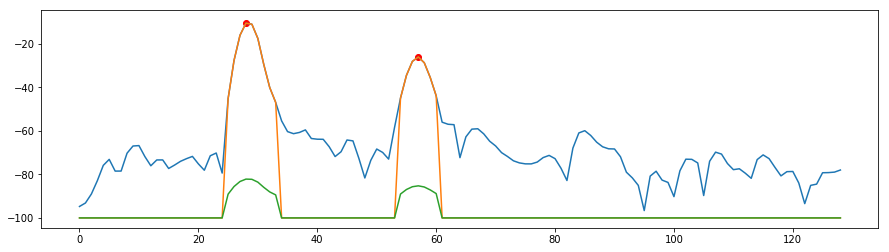

30 => -16.2296308825/45000.0   [30, 34, 61] ==> [-16.22963088 -51.87419252 -43.23296586]


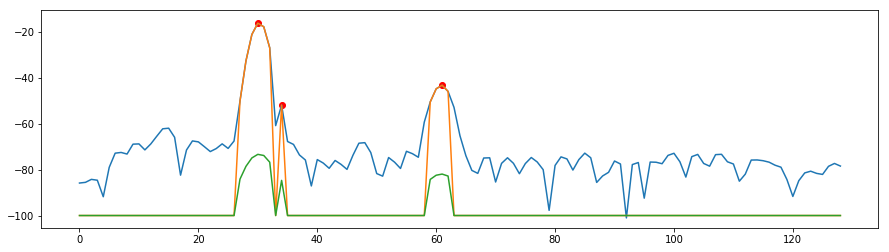

31 => -7.4391742318/46500.0   [31, 62] ==> [ -7.43917423 -27.92566035]


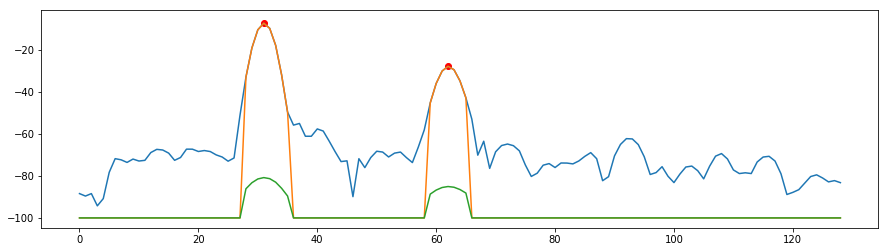

28 => -18.9300730599/42000.0   [28] ==> [-18.93007306]


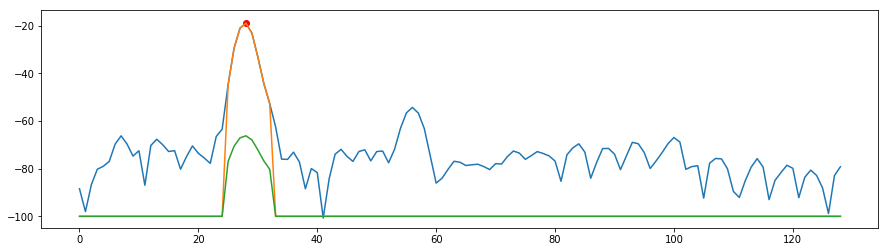

31 => -7.60080459978/46500.0   [31, 62] ==> [ -7.6008046  -42.63467622]


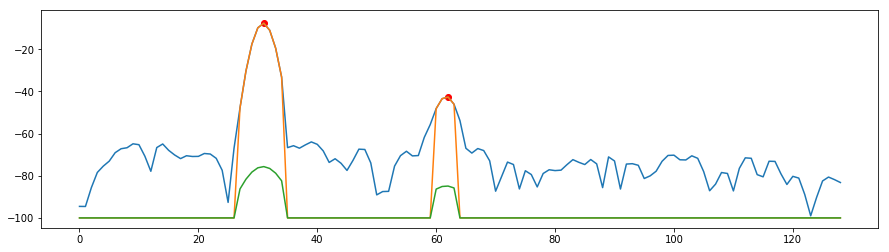

27 => -10.2361118568/40500.0   [27, 55] ==> [-10.23611186 -46.97084862]


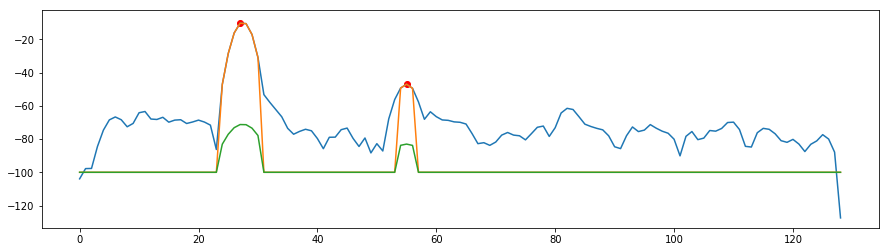

28 => -8.18053394258/42000.0   [28, 57] ==> [ -8.18053394 -42.79946316]


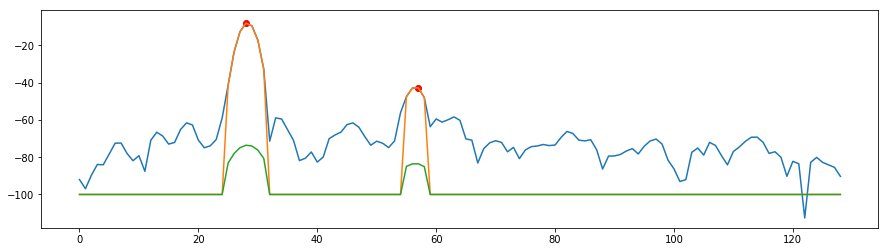

29 => -10.5069138474/43500.0   [29, 58] ==> [-10.50691385 -48.15526756]


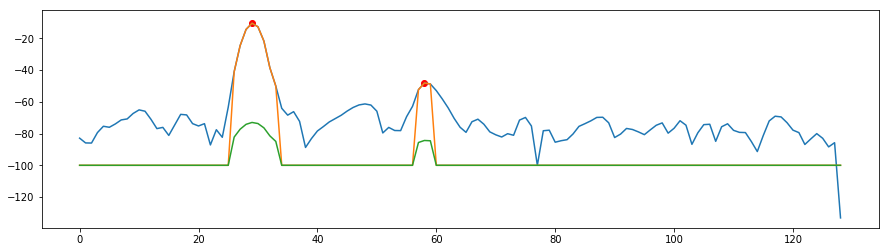

26 => -12.3236710058/39000.0   [26, 49, 52] ==> [-12.32367101 -49.49924601 -52.00051299]


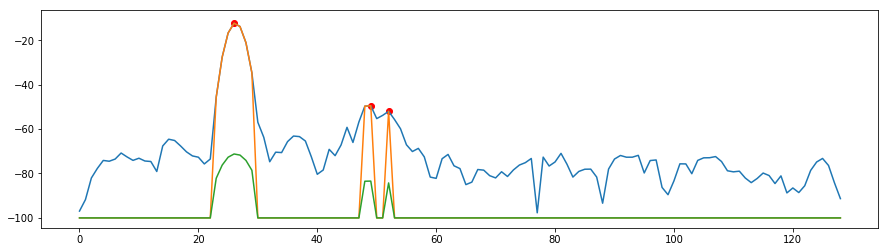

In [26]:
# %%timeit
for idx, index in enumerate(peaks):
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       hamming_window, hamming_dbfs_max)
    # Index for max value in spectrum.
    maxindex = dbfs_spectrum.argmax()
    # Noise.
    db_mean = np.mean(dbfs_spectrum)
    threshold_db = db_mean - (db_mean - db_peak) * 0.5
    dbfs_spectrum_1 = dbfs_spectrum.copy() 
    dbfs_spectrum_1[(dbfs_spectrum < threshold_db)] = -100.0
    # Smooth and find peaks in spectrum.
    ##win = scipy.signal.hann(10) # (35)
    ##filtered = scipy.signal.convolve(dbfs_spectrum_1 + 100.0, win, mode='same') / sum(win)
    ##win = [10.0] * 10
    ##filtered = np.convolve(dbfs_spectrum_1 + 100.0, win, mode='same') / sum(win)
    ##dbfs_spectrum_2 = filtered - 100.0
    ##peakidx = scipy.signal.argrelmax(dbfs_spectrum_2)
    
    #rmse = librosa.feature.rmse(y=dbfs_spectrum_1 + 100.0, hop_length=1, frame_length=16, center=True)
    #dbfs_spectrum_2 = rmse.T - 100.0
    
    centroids = librosa.feature.spectral_centroid(S=dbfs_spectrum_1 + 100.0, n_fft=128, )
    dbfs_spectrum_2 = centroids.T / 3200 - 100.0
    ##print(dbfs_spectrum_2)
    
    localmax_bools = librosa.util.localmax(dbfs_spectrum_2)
    maxindexlist = []
    for index, a in enumerate(localmax_bools):
        if a: maxindexlist.append(index)
            
    peakidx = maxindexlist
    # Convert indexlist to match original signal.
    ##index_list = librosa.frames_to_samples(maxindexlist, hop_length=hop_length)

    
    # Plot.
    print(
        str(maxindex) + ' => ' + str(dbfs_spectrum[maxindex]) + '/' +  \
        str(self_freq_bins_hz[maxindex]) + '   ' + \
        str(peakidx) + ' ==> ' +  \
        str(dbfs_spectrum[peakidx]) +  \
        ''
    )
    plt.plot(dbfs_spectrum)
    plt.plot(dbfs_spectrum_1)
    plt.plot(dbfs_spectrum_2)
    plt.scatter(peakidx, dbfs_spectrum[peakidx], color='r')
    plt.show()